In [1]:
import vio_ort
import matplotlib.pyplot as plt
import os
import json
import cv2
import concurrent.futures
import threading
from collections import defaultdict
import plotly.graph_objects as go

In [2]:
odometry = vio_ort.VIO(lat0=54.889668, lon0=83.1258973333, alt0=0)

# Путь к папке
set_dir = '2024_12_15_15_31_8_num_3'

# Получение всех файлов с расширением .json
json_files = [f for f in os.listdir(set_dir) if f.endswith('.json')]

# Сортировка файлов по имени
json_files.sort()

start = 0
count_json = len(json_files)

lat_VIO = []
lon_VIO = []

lat_GPS = []
lon_GPS = []

alt_VIO = []
alt_GPS = []

In [3]:
# Инициализация структуры для ошибок
fails_collect = defaultdict(lambda: {'num': 0, 'files': []})

In [4]:
lock = threading.Lock()

In [5]:
def register_error(error_type, filename):
    with lock:
        if error_type not in fails_collect:
            fails_collect[error_type] = {'num': 0, 'files': []}
        fails_collect[error_type]['num'] += 1
        fails_collect[error_type]['files'].append(filename)

In [6]:
with open("Debug/debug_output.txt", "w") as f:
    f.write("")

In [7]:
def process_file(filename):
    try:
        with open(f'{set_dir}/{filename}', 'r') as file:
            data = json.load(file)

        if 'GNRMC' not in data or 'VIO' not in data:
            register_error("Missing GNRMC or VIO", filename)
            return

        if data['GNRMC'].get('status') != 'A':
            register_error("GNRMC status not 'A'", filename)
            return

        img_path = f"{set_dir}/{os.path.splitext(filename)[0]}.jpg"
        if not os.path.exists(img_path):
            register_error("Image not found", filename)
            return

        image = cv2.imread(img_path)
        if image is None:
            register_error("Failed to load image", filename)
            return

        try:
            result_vio = odometry.add_trace_pt(image, data)
            
            if 'lat' not in result_vio or 'lon' not in result_vio:
                with open("Debug/debug_output.txt", "a") as f:
                    f.write(f"[VIO] Missing 'lat' or 'lon' in result: {result_vio}\n")
                register_error("VIO result missing 'lat' or 'lon'", filename)
                return

            # Сравниваем с координатами VIO из JSON
            json_vio = data['VIO']
            calculated_lat = result_vio['lat']
            calculated_lon = result_vio['lon']
            original_lat = json_vio.get('lat', 0.0)
            original_lon = json_vio.get('lon', 0.0)

            # Выводим результаты для анализа
            with open("Debug/debug_output.txt", "a") as f:
                f.write(f"File: {filename}\n")
                f.write(f"Original VIO: ({original_lat}, {original_lon})\n")
                f.write(f"Calculated VIO: ({calculated_lat}, {calculated_lon})\n")
                f.write(f"Difference: lat={calculated_lat - original_lat}, lon={calculated_lon - original_lon}\n\n")

            with lock:
                lat_VIO.append(calculated_lat)
                lon_VIO.append(calculated_lon)
                alt_VIO.append(data['VIO']['alt'])
        except Exception as e:
            with open("Debug/debug_output.txt", "a") as f:
                f.write(f"[VIO] Error occurred: {str(e)}\n")
            register_error("VIO processing error", filename)
            return

        try:
            with lock:
                lat_GPS.append(data['GNRMC'].get('lat', 0.0))
                lon_GPS.append(data['GNRMC'].get('lon', 0.0))
                alt_GPS.append(data['GPS_RAW_INT']['alt'])
        except KeyError:
            register_error("GPS data missing", filename)
        
    except json.JSONDecodeError:
        register_error("JSON decode error", filename)
    except Exception:
        register_error("Processing error", filename)

Путем перебора наибольшая выгода при 6 потоках

In [8]:
workers = 6
with concurrent.futures.ThreadPoolExecutor(max_workers=workers) as executor:
        executor.map(process_file, json_files[start:start + count_json])

In [9]:
# Вывод отчетности
print("\nError Report:")
for error_type, error_info in fails_collect.items():
    print(f"{error_type} - {error_info['num']} occurrences")
    print(f"Files: {', '.join(error_info['files'])}")
    print()


Error Report:
GNRMC status not 'A' - 64 occurrences
Files: 1734247869167.json, 1734247868001.json, 1734247868492.json, 1734247868806.json, 1734247868955.json, 1734247869585.json, 1734247869318.json, 1734247869736.json, 1734247869909.json, 1734247869446.json, 1734247871036.json, 1734247870836.json, 1734247870290.json, 1734247870585.json, 1734247871308.json, 1734247871436.json, 1734247871712.json, 1734247872080.json, 1734247871966.json, 1734247871849.json, 1734247871552.json, 1734247873120.json, 1734247872872.json, 1734247872226.json, 1734247873324.json, 1734247873713.json, 1734247873449.json, 1734247873960.json, 1734247873828.json, 1734247874117.json, 1734247874538.json, 1734247874672.json, 1734247874271.json, 1734247874401.json, 1734247872566.json, 1734247874935.json, 1734247874807.json, 1734247875331.json, 1734247875452.json, 1734247875056.json, 1734247875599.json, 1734247875727.json, 1734247876037.json, 1734247875875.json, 1734247875196.json, 1734247876826.json, 1734247876438.json, 

In [10]:
"""for i in range(len(lat_GPS)):
  print(f'Point num {i}')
  print(f'Diff between GPS and VIO: {(lat_GPS[i] - lat_VIO[i])}')
  print(f'GPS lat_: {lat_GPS[0]}')
  print(f'VIO lat_: {lat_VIO[0]}')"""

"for i in range(len(lat_GPS)):\n  print(f'Point num {i}')\n  print(f'Diff between GPS and VIO: {(lat_GPS[i] - lat_VIO[i])}')\n  print(f'GPS lat_: {lat_GPS[0]}')\n  print(f'VIO lat_: {lat_VIO[0]}')"

In [11]:
"""for i in range(len(lon_GPS)):
  print(f'Point num {i}')
  print(f'Diff between GPS and VIO: {(lon_GPS[i] - lon_VIO[i])}')
  print(f'GPS lon: {lon_GPS[0]}')
  print(f'VIO lon: {lon_VIO[0]}')"""

"for i in range(len(lon_GPS)):\n  print(f'Point num {i}')\n  print(f'Diff between GPS and VIO: {(lon_GPS[i] - lon_VIO[i])}')\n  print(f'GPS lon: {lon_GPS[0]}')\n  print(f'VIO lon: {lon_VIO[0]}')"

In [12]:
with open("Debug/debug_points.txt", "w") as f:
    f.write("")
    for i in range(len(lat_GPS)):
      f.write(f'Point num {i}\n')
      f.write(f'{i} point GPS lat: {lat_GPS[i]}\n')
      f.write(f'{i} point VIO lat: {lat_VIO[i]}\n')
      f.write(f'{i} point GPS lon: {lon_GPS[i]}\n')
      f.write(f'{i} point VIO lon: {lon_VIO[i]}\n')

In [13]:
print(len(lat_GPS))
print(len(lat_VIO))

3301
3301


In [14]:
alt_VIO = [ x * 1000 for x in alt_VIO]

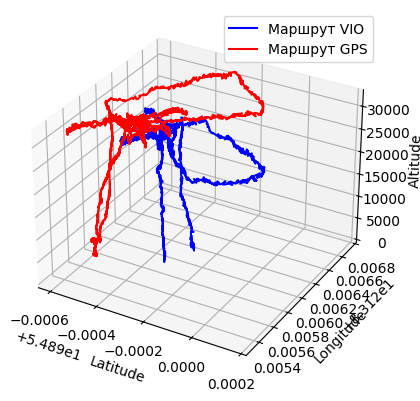

In [15]:
# Создание 3D графика
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Построение маршрута
ax.plot(lat_VIO, lon_VIO, alt_VIO, label='Маршрут VIO', color='blue')
ax.plot(lat_GPS, lon_GPS, alt_GPS, label='Маршрут GPS', color='red')

# Настройки графика
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Altitude')
ax.legend()

# Отображение графика
plt.show()


In [16]:
draw_cinema = False

In [ ]:
if draw_cinema:
    # Пример данных (замените на ваши данные)
    lat = lat_GPS
    lon = lon_GPS
    alt = alt_GPS

    """lat = lat_VIO
    lon = lon_VIO
    alt = alt_VIO"""

    step = 1

    # Создание фигуры с анимацией
    fig = go.Figure()

    # Добавление начального состояния
    fig.add_trace(go.Scatter3d(
        x=[lat[0]],
        y=[lon[0]],
        z=[alt[0]],
        mode='lines+markers',
        line=dict(color='blue', width=2),
        marker=dict(size=4, color=alt[0], colorscale='Viridis')
    ))

    # Создание кадров анимации
    frames = []
    for i in range(1, len(lat)):
        frame = go.Frame(
            data=[go.Scatter3d(
                x=lat[:i+step],  # Данные до текущего кадра
                y=lon[:i+step],
                z=alt[:i+step],
                mode='lines+markers',
                line=dict(color='blue', width=2),
                marker=dict(size=4, color=alt[:i+step], colorscale='Viridis')
            )]
        )
        frames.append(frame)

    fig.frames = frames

    # Добавление кнопок управления анимацией
    fig.update_layout(
        updatemenus=[{
            'buttons': [
                {
                    'args': [None, {'frame': {'duration': 50, 'redraw': True}, 'fromcurrent': True}],
                    'label': 'Старт',
                    'method': 'animate'
                },
                {
                    'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                    'label': 'Стоп',
                    'method': 'animate'
                }
            ],
            'direction': 'left',
            'pad': {'r': 10, 't': 87},
            'showactive': False,
            'type': 'buttons',
            'x': 0.1,
            'xanchor': 'right',
            'y': 0,
            'yanchor': 'top'
        }]
    )

    # Настройка размеров и осей
    fig.update_layout(
        scene=dict(
            xaxis_title='Широта',
            yaxis_title='Долгота',
            zaxis_title='Высота',
        ),
        title='Анимация маршрута дрона',
        width=1200,
        height=800,
    )

    fig.show()

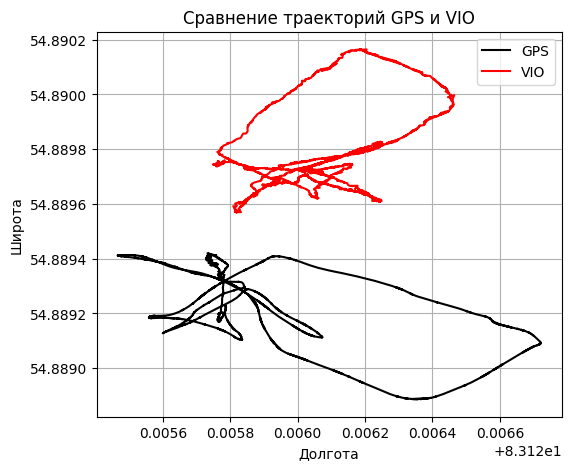

In [18]:
# Списки для данных
gps_lats = lat_GPS.copy()
gps_lons = lon_GPS.copy()
vio_lats = lat_VIO.copy()
vio_lons = lon_VIO.copy()

gps_lats = [ -x + 2 * 54.8894116667 for x in gps_lats]

#vio_lats = [ -x + 2 * 54.8894116667 for x in vio_lats]
vio_lons = [ -x + 2 * 83.1258973333 for x in vio_lons]

# Визуализация данных с аномалиями
plt.figure(figsize=(6, 5))

plt.plot(gps_lons, gps_lats, color="black", label="GPS")
plt.plot(vio_lons, vio_lats, color="red", label="VIO")

plt.title("Сравнение траекторий GPS и VIO")
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.legend()
plt.grid()
plt.show()

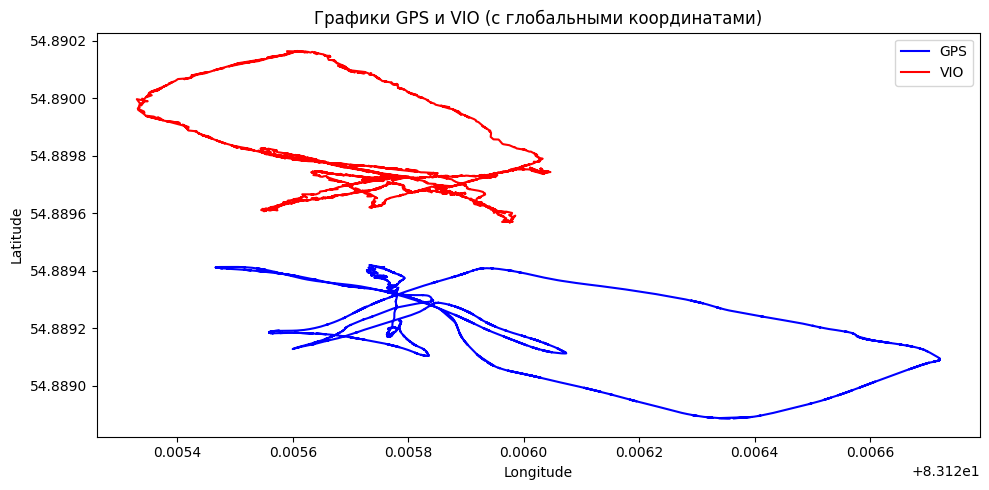

In [19]:
copy_lat_VIO = lat_VIO.copy()
copy_lon_VIO = lon_VIO.copy()

copy_lat_GPS = lat_GPS.copy()
copy_lon_GPS = lon_GPS.copy()

# Создаем фигуру и оси
plt.figure(figsize=(10, 5))

# Преобразование для глобальных координат широты
copy_lat_GPS = [ -x + 2 * 54.8894116667 for x in copy_lat_GPS]

# Рисуем первый график (GPS)
plt.plot(copy_lon_GPS, copy_lat_GPS, label='GPS', color='blue')

# Рисуем второй график (VIO)
plt.plot(copy_lon_VIO, copy_lat_VIO, label='VIO', color='red')

# Добавляем заголовок и метки осей
plt.title('Графики GPS и VIO (с глобальными координатами)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Добавляем легенду
plt.legend()

# Отображение графика
plt.tight_layout()
plt.show()